# Analysis of domain name popularity in African countries

We scraped the data from https://www.alexa.com/topsites/countries. To be able to retrieve historical data, we used the Way back Machine downloader https://github.com/hartator/wayback-machine-downloader.

We retrieved Alexa top 50 pages from 2009 to 2019.

In this analysis, we are going to study 5 African countries namely: South Africa, Nigeria, Kenya, Egypt and DRC

In [23]:
import numpy as np
import pandas as pd

import itertools

import matplotlib.pyplot as plt

ccs = [
'EG', 'BJ', 'CI', 'CV', 'GH', 'GM', 'GN', 'GW', 'AO', 'CF', 'CG', 'CM', 'GA', 'GQ', 'TD', 'BI', 'DJ', 'ER', 'ET', 'KM', 'BW', 'MA', 'SD', 'TN', 'LR', 'ML', 'MR', 'NE', 'NG', 'SL', 'SN', 'TG', 'ST', 'KE', 'MG', 'MU', 'MW', 'MZ', 'RE', 'RW', 'SC', 'SO', 'UG', 'LS', 'NA', 'SZ', 'ZA', 'DZ', 'EH', 'LY', 'BF', 'SH', 'CD', 'TZ', 'YT', 'ZM', 'ZW']

In [24]:
df = pd.read_csv('data/alexatop50/alexatop50_2009_2019.csv')
df.head()
df.dtypes

date       object
ranking     int64
domain     object
cc         object
dtype: object

In [29]:
df_za = df[(df.cc=='ZA') & (df.ranking < 11)]
df_za

,date,ranking,domain,cc
1451,2019-05-14 20:36:46,1,google.com,ZA
1452,2019-05-14 20:36:46,2,youtube.com,ZA
1453,2019-05-14 20:36:46,3,google.co.za,ZA
1454,2019-05-14 20:36:46,4,facebook.com,ZA
1455,2019-05-14 20:36:46,5,dstv.com,ZA
1456,2019-05-14 20:36:46,6,yahoo.com,ZA
1457,2019-05-14 20:36:46,7,wikipedia.org,ZA
1458,2019-05-14 20:36:46,8,office.com,ZA
1459,2019-05-14 20:36:46,9,fnb.co.za,ZA
1460,2019-05-14 20:36:46,10,microsoftonline.com,ZA


In [27]:
#df_za.set_index(['date','rank','domain']).Import.unstack().reset_index()

df_za_T = df_za.pivot_table(index=['date'], columns=['domain'],
                     values='ranking', aggfunc='first', fill_value=0)

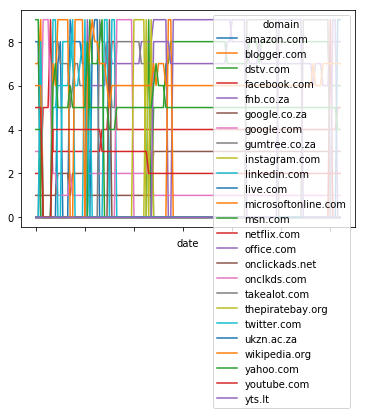

In [28]:
lines = df_za_T.plot.line()